## Cifar 10


In [51]:
%matplotlib inline

import matplotlib
import scipy.io
import matplotlib.pyplot as plt

import cPickle
import numpy as np
from scipy.misc import imsave
from IPython.display import Image, display, HTML

## Step 1: Preprocess the data

In [5]:
!mkdir /tmp/cifar10

mkdir: cannot create directory ‘/tmp/cifar10’: File exists


In [6]:
with open("/datasets/cifar-10-batches-py/batches.meta") as fd:
    meta = cPickle.load(fd)
print meta

{'num_cases_per_batch': 10000, 'label_names': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], 'num_vis': 3072}


In [67]:
def load_cifar10_image_list(filepath):
    images = []
    labels = []
    with open(filepath, 'rb') as fd:
        d = cPickle.load(fd)
        for image, label, filename in zip(d['data'], d['labels'], d['filenames']):
            x = np.array(image)
            x = np.dstack((x[:1024], x[1024:2048], x[2048:]))
            x = x.reshape(32,32,3)
            filename="/tmp/cifar10/"+filename
            imsave(filename, x)
            images.append(filename)
            labels.append(label)
    return images, labels

In [7]:
x_train = []
y_train = []

for batch in range(1,6):
    batch_name = '/datasets/cifar-10-batches-py/data_batch_%d' % batch
    x,y = load_cifar10_image_list(batch_name)
    x_train.extend(x)
    y_train.extend(y)

In [65]:
!ls /datasets/cifar-10-batches-py/

batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch


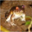

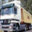

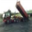

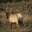

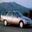

In [54]:
for x in x_train[:5]:
    display(Image(filename=x))

In [55]:
len(x_train)

50000

In [68]:
batch_test = '/datasets/cifar-10-batches-py/test_batch'
x_test, y_test = load_cifar10_image_list(batch_test)

In [69]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  ----------------------
H2O cluster uptime:         1 day 21 hours 57 mins
H2O cluster version:        3.11.0.99999
H2O cluster version age:    2 days
H2O cluster name:           fmilo
H2O cluster total nodes:    1
H2O cluster free memory:    8.43 Gb
H2O cluster total cores:    40
H2O cluster allowed cores:  40
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
Python version:             2.7.12 final
--------------------------  ----------------------

In [70]:
train_df = {"x": x_train, "y": y_train }

In [72]:
test_df = {"x" : x_test, "y": y_test }

In [71]:
train_hf = h2o.H2OFrame.from_python(train_df)

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%


In [73]:
test_hf = h2o.H2OFrame.from_python(test_df)

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%


Let's 1 hot encode the class

In [84]:
train_hf['y'] = train_hf['y'].asfactor()
test_hf['y'] = test_hf['y'].asfactor()

In [85]:
from h2o.estimators.deepwater import H2ODeepWaterEstimator

In [94]:
vgg_model = H2ODeepWaterEstimator(
    epochs=10, 
    learning_rate=1e-3, 
    mini_batch_size=64,
    network='VGG', 
    image_shape=[32,32], 
    channels=3,
    score_interval=0, 
    train_samples_per_iteration=1000,
    gpu=True
)

In [96]:
vgg_model.train(x=['x'], y='y', training_frame=train_hf)

deepwater Model Build progress: |█████████████████████████████████████████████████████████████| 100%


In [92]:
error = vgg_model.model_performance(train=True)
print "model error:", error

model error: None
